# Explore SO-CHIC data (processed by MITprof)

Including XBT, CBT, ARGO, and SEAL profiles in the SO-WISE region. The profiles have been processed by Shenjie Zhou using the MITprof tool. Specifically, this means that they have been interpolated onto a standard set of depth levels, and the names have been brought into consistency with the MITprof format. 

The test values from MITprof are as follows:
-   0 = valid data
-   1 = not enough data near standard level
-   2 = absurd sal value
-   3 = doubtful profiler (based on our own evaluations)
-   4 = doubtful profiler (based on Argo grey list)
-   5 = high climatology/atlas cost - all four of them
-   6 = bad profile location, date, or pressure

More info on MITprof here:
https://github.com/MITgcm/MITprof

#### Import modules

In [1]:
# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import dask
from dask.distributed import Client
import dask
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# pyxpcm, xarray, dask
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
import random

#### Select subset of profiles for plotting

In [2]:
subset = range(1100,1200,1)

#### Start local dask client

In [3]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:62822 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


# XBT

#### Open XBT dataset, carry out basic processing

In [4]:
data_loc = '../data_so-chic/processed_MITprof/'

# open all XBT profiles
xbt = xr.open_mfdataset(data_loc + 'XBT/wod18_XBT_*.nc', concat_dim='iPROF', combine='nested')

# only keep a subset of the variables
xbt = xbt.get(['prof_depth','prof_date','prof_YYYYMMDD','prof_HHMMSS','prof_lon','prof_lat',
               'prof_basin','prof_point','prof_descr','prof_T','prof_Tweight','prof_Testim',
               'prof_Tweight','prof_Terr','prof_Tflag'])

# extract vector of depths, add DataArray to Dataset 
xbt = xbt.assign(depth=xbt.prof_depth[0,:])

# set depth as a coordinate
xbt = xbt.set_coords('depth')

# rename some of the variables
xbt = xbt.rename({'iPROF':'profile',
                  'prof_lon':'lon',
                  'prof_lat':'lat'})

# drop some variables
xbt = xbt.drop_vars({'prof_depth'})

# change lon and lat to coordinates
#xbt = xbt.set_coords({'lon','lat'})

# rename iDEPTH to just 'depth'
xbt = xbt.rename({'iDEPTH':'depth'})

# examine dataframe
xbt

<xarray.Dataset>
Dimensions:        (depth: 45, profile: 66565)
Coordinates:
  * depth          (depth) float64 dask.array<chunksize=(45,), meta=np.ndarray>
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    lon            (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_basin     (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_point     (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_descr     (profile) |S30 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Tweight   (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Testim    (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Terr      (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Tflag     (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
Attributes:
    Format:   The contents of this MITprof file were processed \nusing the MI...
    date:     18-May-2021

#### Example of converting to datetime64 format

In [5]:
ntime_array_ymd = xbt.prof_YYYYMMDD.values[11200]
ntime_array_hms = xbt.prof_HHMMSS.values[11200]
s_ymd = str(ntime_array_ymd)
s_hms = str(ntime_array_hms)
date_str_ymd = s_ymd[0:4] + '-' + s_ymd[4:6] + '-' + s_ymd[6:8]
date_str_hms = s_hms[0:2] + ':' + s_hms[2:4] + ':' + s_hms[4:6]
date_str =  date_str_ymd + ' ' + date_str_hms 
np.datetime64(date_str,'s')

numpy.datetime64('1982-06-10T23:07:47')

#### Create new datetime data variable to be added to Dataset

In [6]:
# select MITprof values
ntime_array_ymd = xbt.prof_YYYYMMDD.values
ntime_array_hms = xbt.prof_HHMMSS.values

# select size
nsize = ntime_array_ymd.size
#nsize = 7

# create array of zeros
time = np.zeros((nsize,),dtype='datetime64[s]')

# loop over all values, convert do datetime64[s]
for i in range(0,nsize,1):
    # extract strings for ymd and hms
    s_ymd = str(ntime_array_ymd[i]).zfill(8)
    s_hms = str(ntime_array_hms[i]).zfill(8)
    # problem with 24:00:00
    if s_hms=='240000.0':
        s_hms = '235959.0'
    # format into yyyy-mm-dd hh:mm:ss
    date_str_ymd = s_ymd[0:4] + '-' + s_ymd[4:6] + '-' + s_ymd[6:8]
    date_str_hms = s_hms[0:2] + ':' + s_hms[2:4] + ':' + s_hms[4:6]
    date_str =  date_str_ymd + ' ' + date_str_hms
    # convert to datetime64 (the 's' stands for seconds)
    time[i] = np.datetime64(date_str,'s')
    
# convert to pandas datetime (may not may not end up using this)
#time_pd = pd.to_datetime(time)
    
# convert time array into a DataArray
da = xr.DataArray(time, dims=['profile'])

# add DataArray as new data variable to DataSet
xbt['time'] = da

# set time as a coordinate
xbt = xbt.set_coords('time')

# examine Dataset again
xbt

<xarray.Dataset>
Dimensions:        (depth: 45, profile: 66565)
Coordinates:
  * depth          (depth) float64 dask.array<chunksize=(45,), meta=np.ndarray>
    time           (profile) datetime64[ns] 1966-10-29T16:30:00 ... 2020-09-0...
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    lon            (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_basin     (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_point     (profile) float64 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_descr     (profile) |S30 dask.array<chunksize=(708,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Tweight   (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Testim    (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Terr      (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
    prof_Tflag     (profile, depth) float64 dask.array<chunksize=(708, 45), meta=np.ndarray>
Attributes:
    Format:   The contents of this MITprof file were processed \nusing the MI...
    date:     18-May-2021

#### Plot spatial distribution of XBT profiles

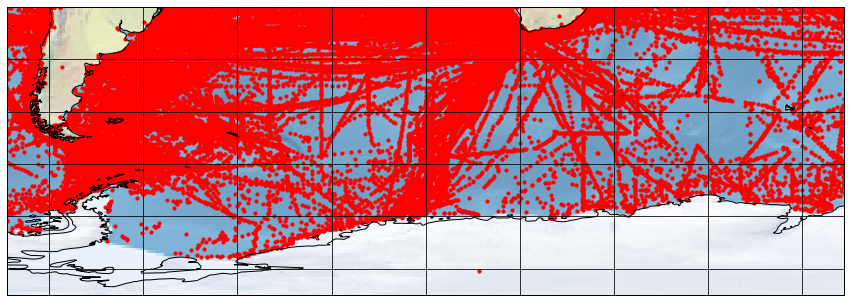

In [7]:
# extract lat/lon values
lons_plot = xbt.isel(depth=0).lon.values
lats_plot = xbt.isel(depth=0).lat.values

#colormap 
plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
CS = plt.scatter(lons_plot-360, 
                 lats_plot, 
                 marker='o',
                 color='red',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.stock_img()
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

We see that the coverage in space is good in the subtropical Atlantic, Drake Passage, and in a bundle of lines between Antarctica and South Africa. There are some profiles in the Weddell Sea, but it is not especially well covered. This probably isn't a huge problem for the coarse resolution state estimate, as it will still be constrained by data from the entire domain. However, we probably won't use XBT data in any clustering work, as it only features temperature. Ideally, we would have both temperature and salinity for clustering applications. 

#### Plot potential temperatures, weights, estim, and err across entire dataset

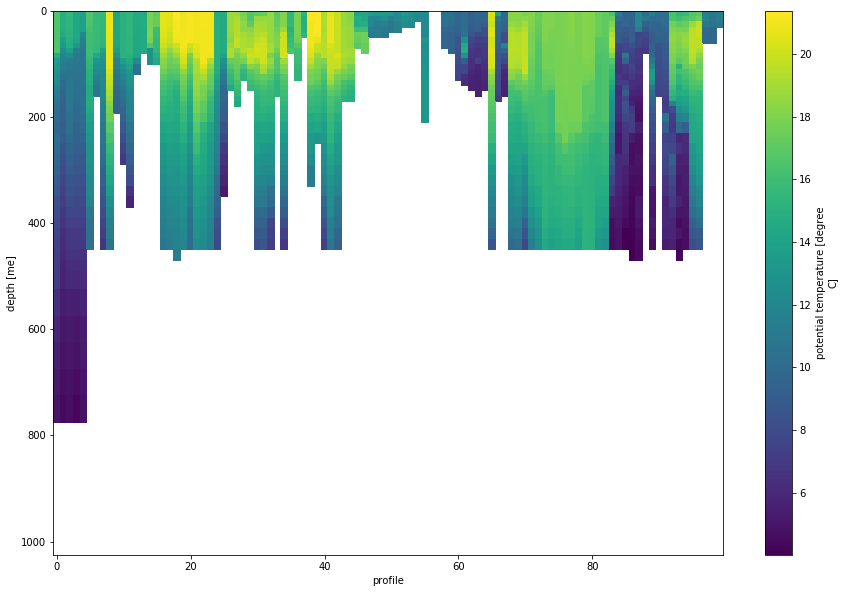

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
xbt.prof_T[subset].plot(y='depth', yincrease=False)

The XBT data has been interpolated onto a standard set of depth levels. Many of the profiles only cover thetop 100-200m, with a few going down below 400m. 

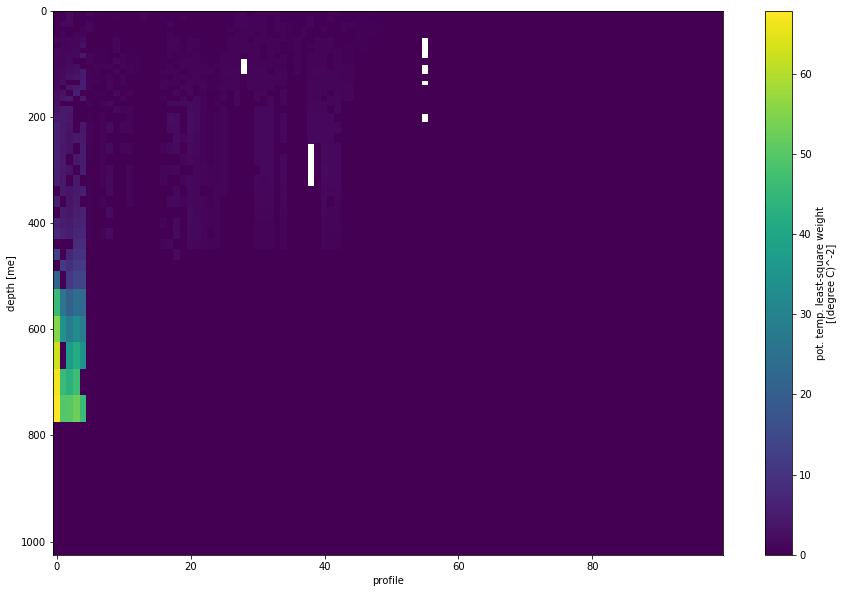

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
xbt.prof_Tweight[subset].plot(y='depth', yincrease=False)

The weights above are used in the cost function. Note that some of the surface is downweighted. This may be due to the presence of eddies; the weights are usually inversely proportional to the square of the combined data and model variance, which includes some sample variance. 

The approach towards the weights are documented in Appendix D of [Forget et al. (2015)](https://gmd.copernicus.org/articles/8/3071/2015/) and in the references therein.

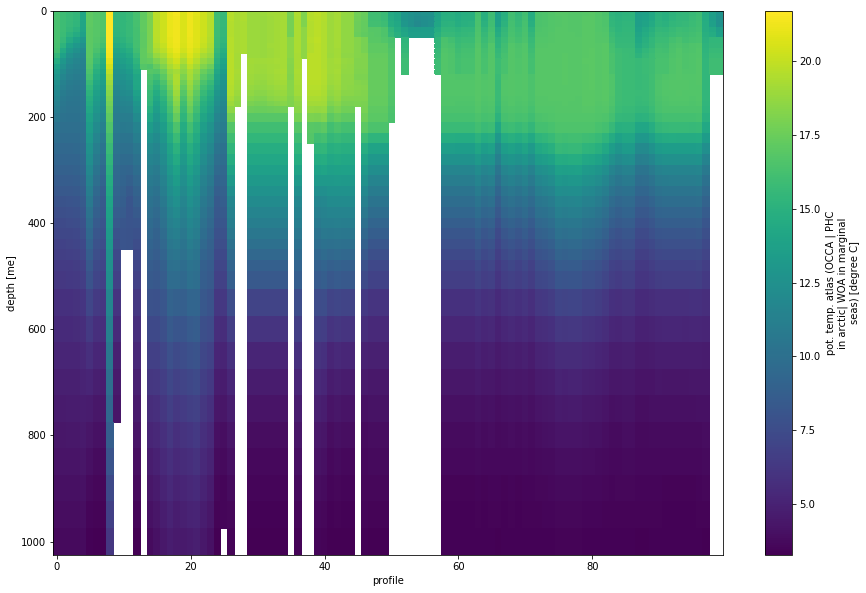

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
xbt.prof_Testim[subset].plot(y='depth', yincrease=False)

The above estimates come from various ocean atlases, to provide a kind of starting point where there is no data vailable. 

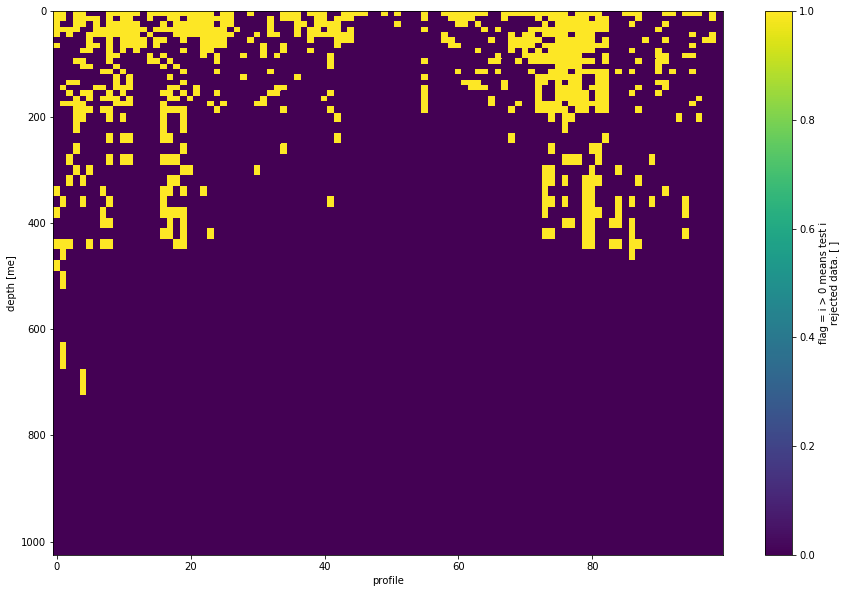

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
xbt.prof_Tflag[subset].plot(y='depth', yincrease=False)

The flag code i=1 indicates that there is not enough data near the standard level to be useful. This indicates that if we want to use the XBT data, we may need to change the standard levels. 

The strictest approach would be to discard any data with a flag i>0. This would apparently eliminate a lot of the XBT data. 

# CTD

In [12]:
data_loc = '../data_so-chic/processed_MITprof/'

# open all ctd profiles
ctd = xr.open_mfdataset(data_loc + 'CTD/wod18_CTD_*.nc', concat_dim='iPROF', combine='nested')

# only keep a subset of the variables
ctd = ctd.get(['prof_depth','prof_date','prof_YYYYMMDD','prof_HHMMSS','prof_lon','prof_lat',
               'prof_basin','prof_point','prof_descr',
               'prof_T','prof_Tweight','prof_Testim','prof_Tweight','prof_Terr','prof_Tflag',
               'prof_S','prof_Sweight','prof_Sestim','prof_Sweight','prof_Serr','prof_Sflag'])

# extract vector of depths, add DataArray to Dataset 
ctd = ctd.assign(depth=ctd.prof_depth[0,:])

# set depth as a coordinate
ctd = ctd.set_coords('depth')

# rename some of the variables
ctd = ctd.rename({'iPROF':'profile',
                  'prof_lon':'lon',
                  'prof_lat':'lat'})

# drop some variables
ctd = ctd.drop_vars({'prof_depth'})

# rename iDEPTH to just 'depth'
ctd = ctd.rename({'iDEPTH':'depth'})

# examine dataframe
ctd

<xarray.Dataset>
Dimensions:        (depth: 89, profile: 41743)
Coordinates:
  * depth          (depth) float64 dask.array<chunksize=(89,), meta=np.ndarray>
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    lon            (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    prof_basin     (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    prof_point     (profile) float64 dask.array<chunksize=(1021,), meta=np.ndarray>
    prof_descr     (profile) |S30 dask.array<chunksize=(1021,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Tweight   (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Testim    (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Terr      (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Tflag     (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_S         (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Sweight   (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Sestim    (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Serr      (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
    prof_Sflag     (profile, depth) float64 dask.array<chunksize=(1021, 89), meta=np.ndarray>
Attributes:
    Format:   The contents of this MITprof file were processed \nusing the MI...
    date:     18-May-2021

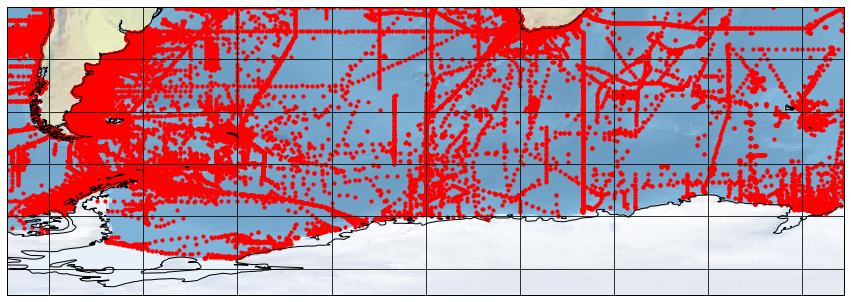

In [13]:
# extract lat/lon values
lons_plot = ctd.isel(depth=0).lon.values
lats_plot = ctd.isel(depth=0).lat.values

#colormap 
plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
CS = plt.scatter(lons_plot-360, 
                 lats_plot, 
                 marker='o',
                 color='red',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.stock_img()
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

The CTD data comes from various ship-tracks; many of the standard lines of occupation are evident in the above spatial distribution. There are a decent number of tracks in the Weddell Sea, including some along the apparent ice shelf front. 

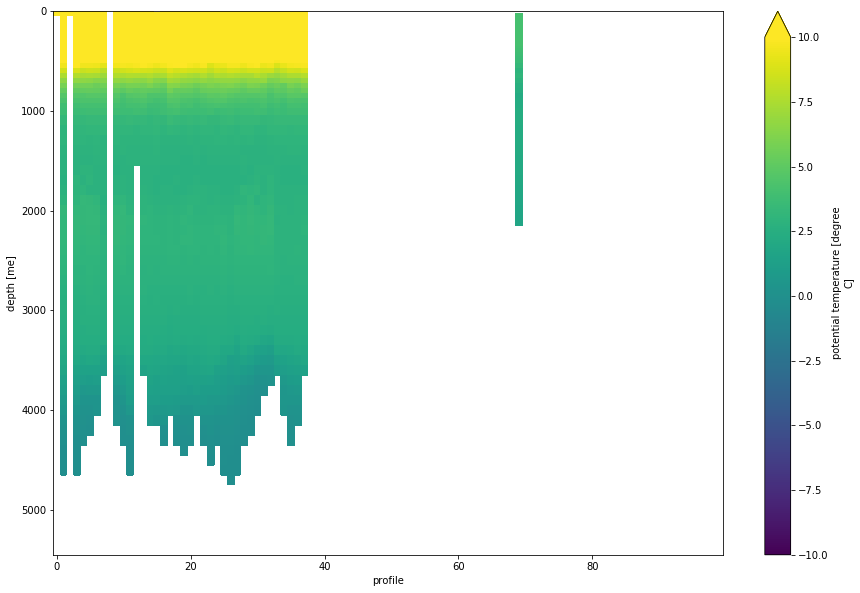

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_T[subset].plot(y='depth', yincrease=False, vmin=-10, vmax=10)

The above profile subset shows a relatively straightforward warm surface and cooler interior. 

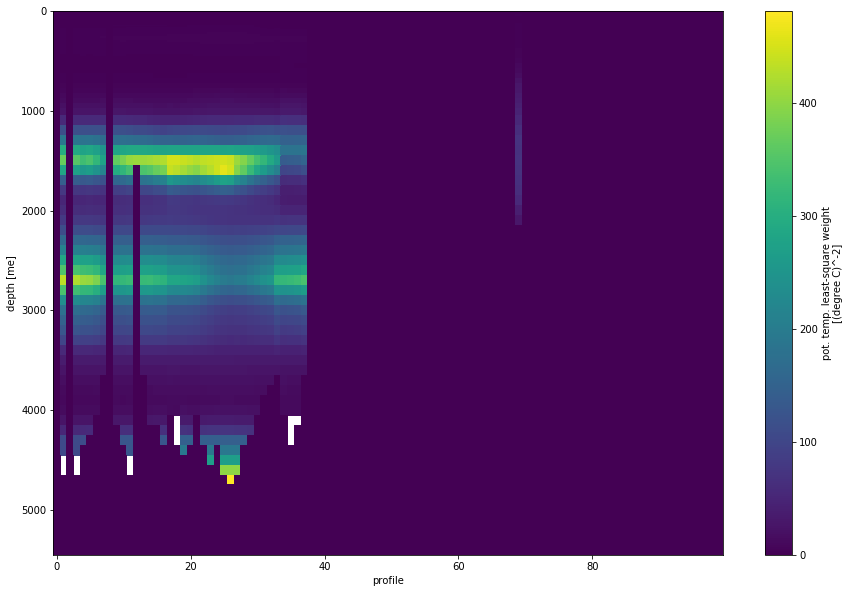

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_Tweight[subset].plot(y='depth', yincrease=False)

Interestingly, again the weights are much larger in the subsurface; I suppose that the sample variance is smaller there, leading to larger weights. 

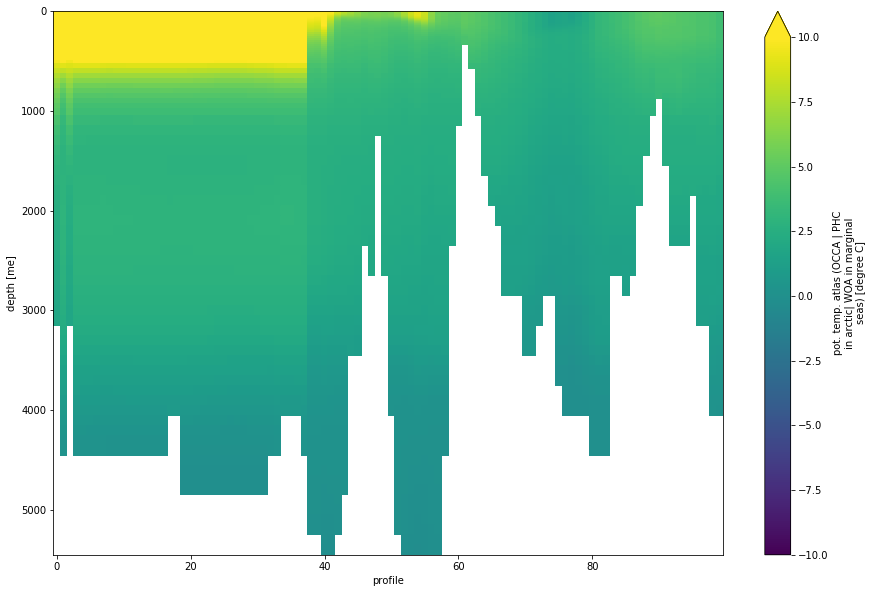

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_Testim[subset].plot(y='depth', yincrease=False, vmin=-10, vmax=10)

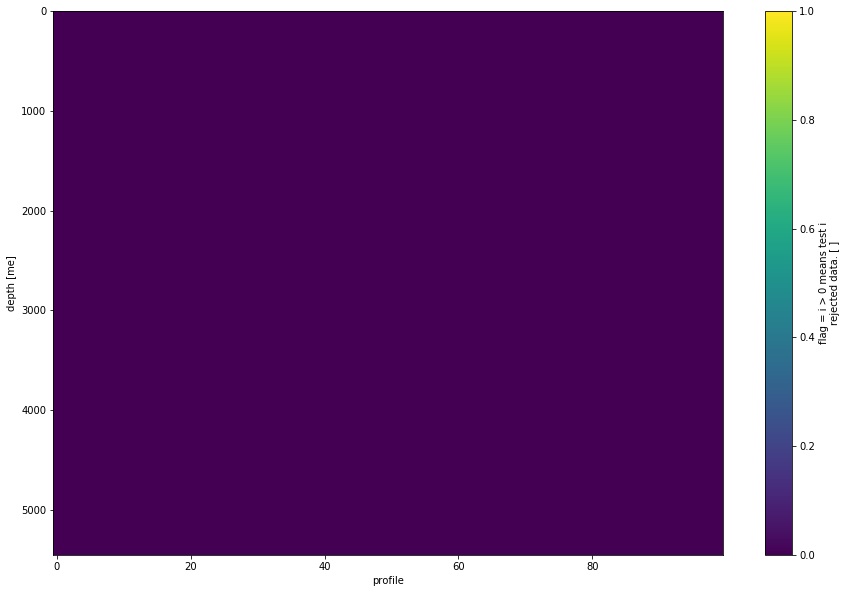

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_Tflag[subset].plot(y='depth', yincrease=False, vmin=0, vmax=1)

If the flags are any indication, then the CTD data is more reliable than the XBT data. That's expected.

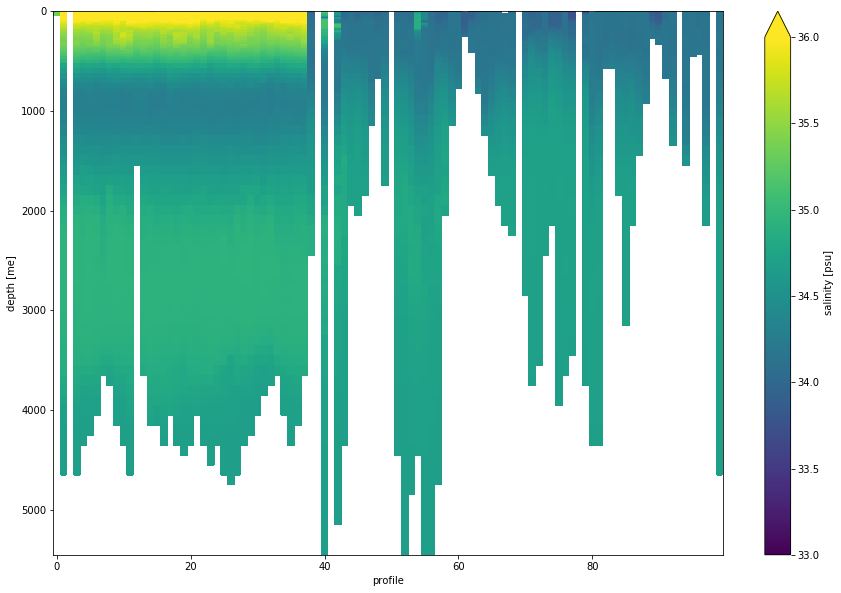

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_S[subset].plot(y='depth', yincrease=False, vmin=33, vmax=36)

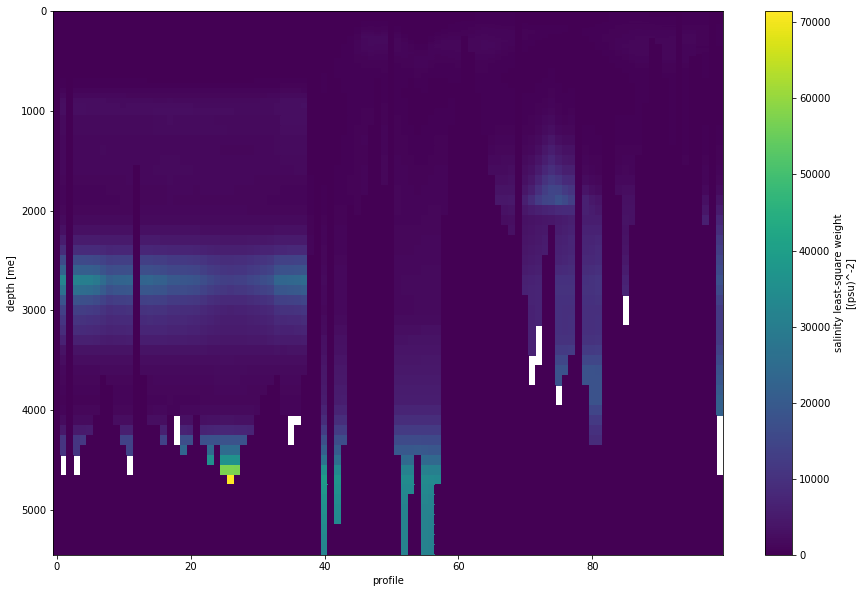

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_Sweight[subset].plot(y='depth', yincrease=False)

Again, the weights as calculated by the sample variance are larger in the subsurface. 

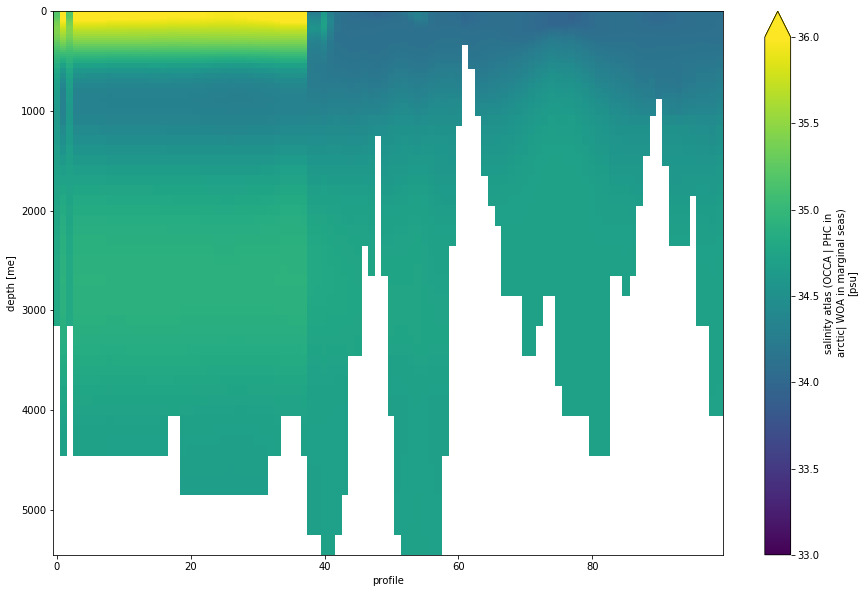

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_Sestim[subset].plot(y='depth', yincrease=False, vmin=33, vmax=36)

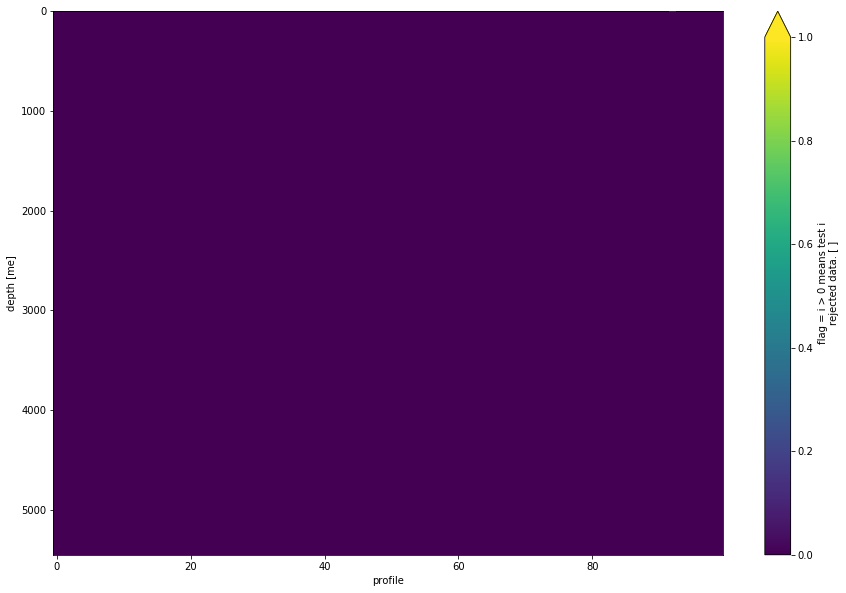

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
ctd.prof_Sflag[subset].plot(y='depth', yincrease=False, vmin=0, vmax=1)

# ARGO

In [22]:
data_loc = '../data_so-chic/processed_MITprof/'

# open all ctd profiles
argo = xr.open_mfdataset(data_loc + 'FLOATS/FLOATS_*.nc', concat_dim='iPROF', combine='nested')

# only keep a subset of the variables
argo = argo.get(['prof_depth','prof_date','prof_YYYYMMDD','prof_HHMMSS','prof_lon','prof_lat',
                 'prof_basin','prof_point','prof_descr',
                 'prof_T','prof_Tweight','prof_Testim','prof_Tweight','prof_Terr','prof_Tflag',
                 'prof_S','prof_Sweight','prof_Sestim','prof_Sweight','prof_Serr','prof_Sflag'])

# extract vector of depths, add DataArray to Dataset 
argo = argo.assign(depth=argo.prof_depth[0,:])

# set depth as a coordinate
argo = argo.set_coords('depth')

# rename some of the variables
argo = argo.rename({'iPROF':'profile',
                    'prof_lon':'lon',
                    'prof_lat':'lat'})

# drop some variables
argo = argo.drop_vars({'prof_depth'})

# rename iDEPTH to just 'depth'
argo = argo.rename({'iDEPTH':'depth'})

# examine dataframe
argo

<xarray.Dataset>
Dimensions:        (depth: 55, profile: 234553)
Coordinates:
  * depth          (depth) float64 dask.array<chunksize=(55,), meta=np.ndarray>
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lon            (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    prof_basin     (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    prof_point     (profile) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    prof_descr     (profile) |S30 dask.array<chunksize=(58,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Tweight   (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Testim    (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Terr      (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Tflag     (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_S         (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Sweight   (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Sestim    (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Serr      (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
    prof_Sflag     (profile, depth) float64 dask.array<chunksize=(58, 55), meta=np.ndarray>
Attributes:
    Format:   The contents of this MITprof file were processed \nusing the MI...
    date:     12-May-2021

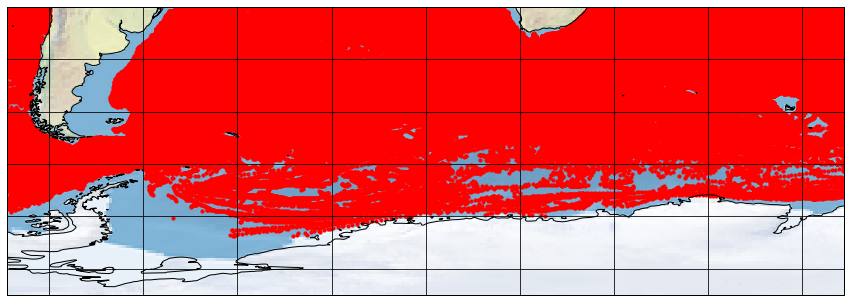

In [23]:
# extract lat/lon values
lons_plot = argo.isel(depth=0).lon.values
lats_plot = argo.isel(depth=0).lat.values

#colormap 
plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
CS = plt.scatter(lons_plot-360, 
                 lats_plot, 
                 marker='o',
                 color='red',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.stock_img()
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

Argo profiles have excellent coverage of most of the domain, except for the Weddell Sea.

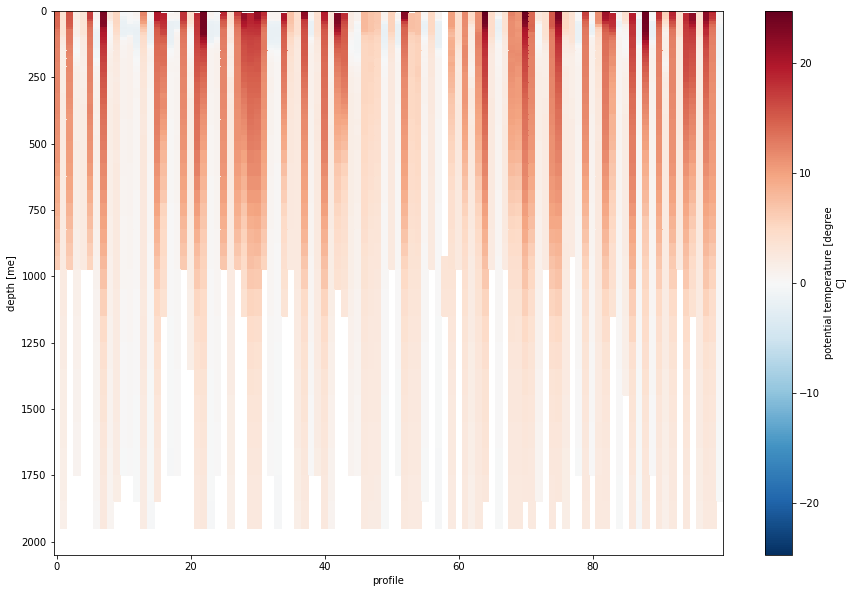

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
argo.prof_T[subset].plot(y='depth', yincrease=False)

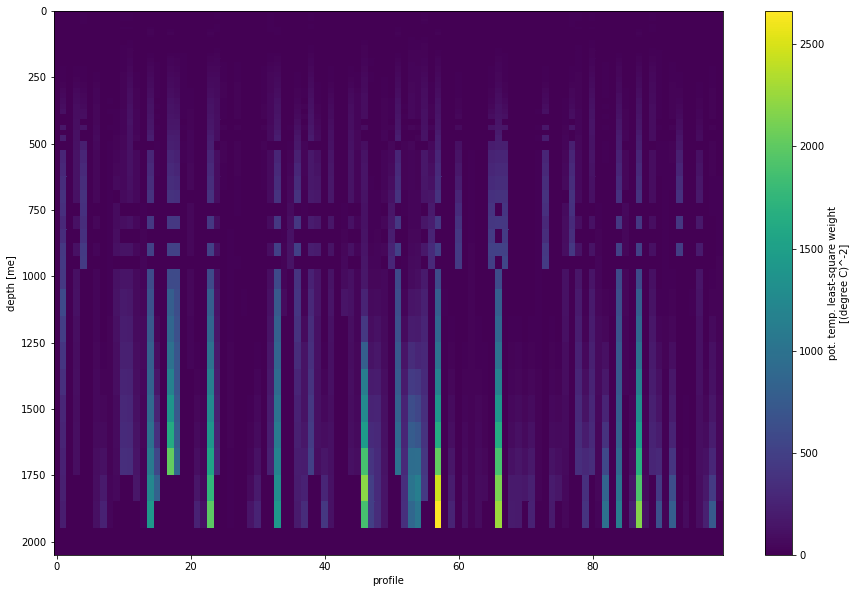

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
argo.prof_Tweight[subset].plot(y='depth', yincrease=False)

Again, the weights are much larger in the subsurface, probably due to the sample variance being smaller in the subsurface. 

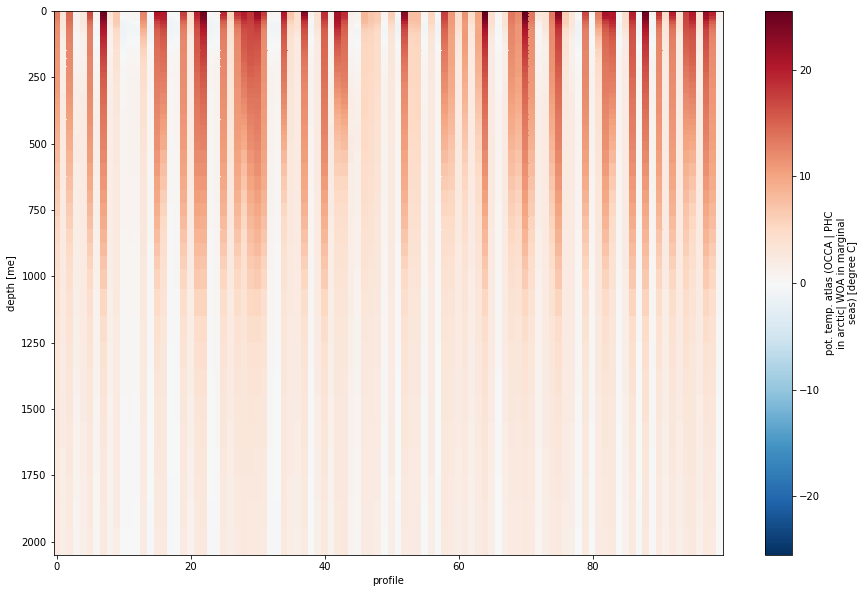

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
argo.prof_Testim[subset].plot(y='depth', yincrease=False)

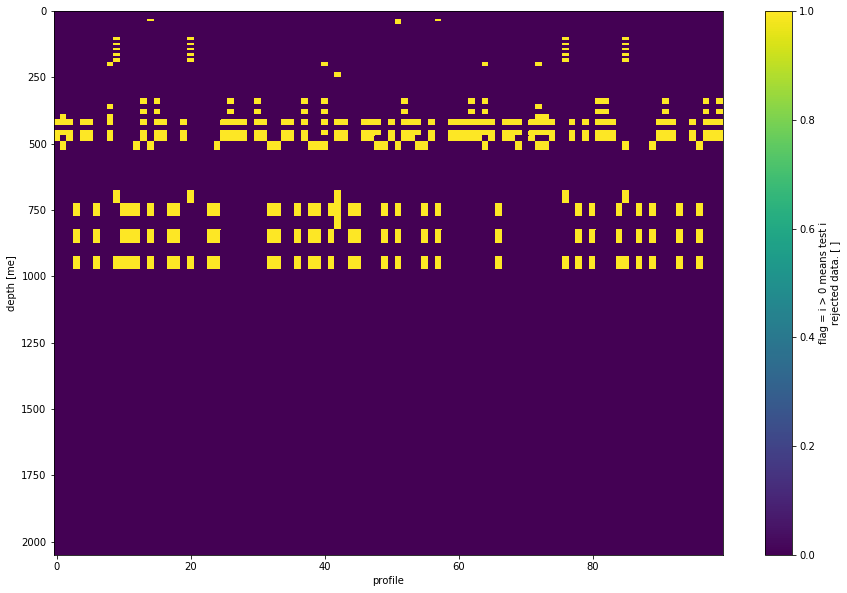

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
argo.prof_Tflag[subset].plot(y='depth', yincrease=False)

The flag values i=1 above indicate that there is not enough data near that standard level to be useful. This indicates that we might need to tweak the standard levels. 

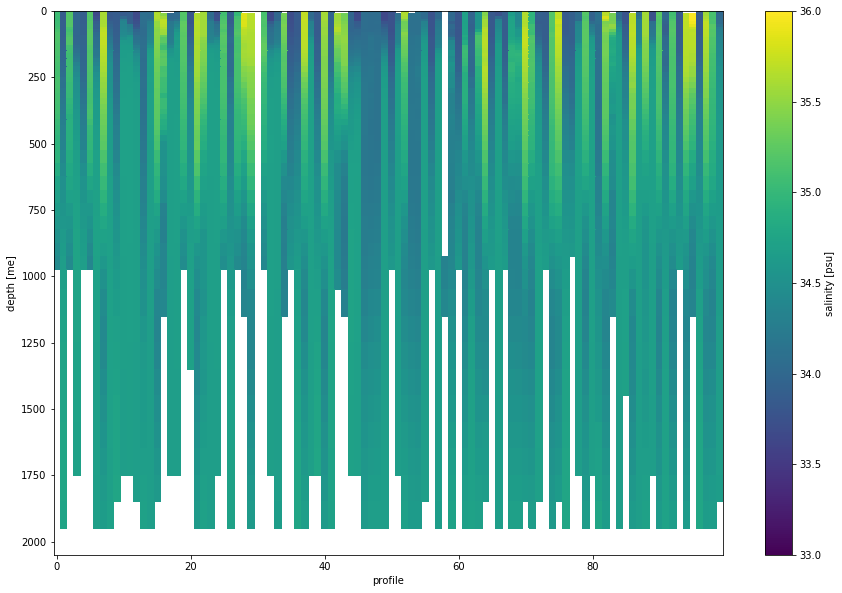

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
argo.prof_S[subset].plot(y='depth', yincrease=False, vmin=33, vmax=36)

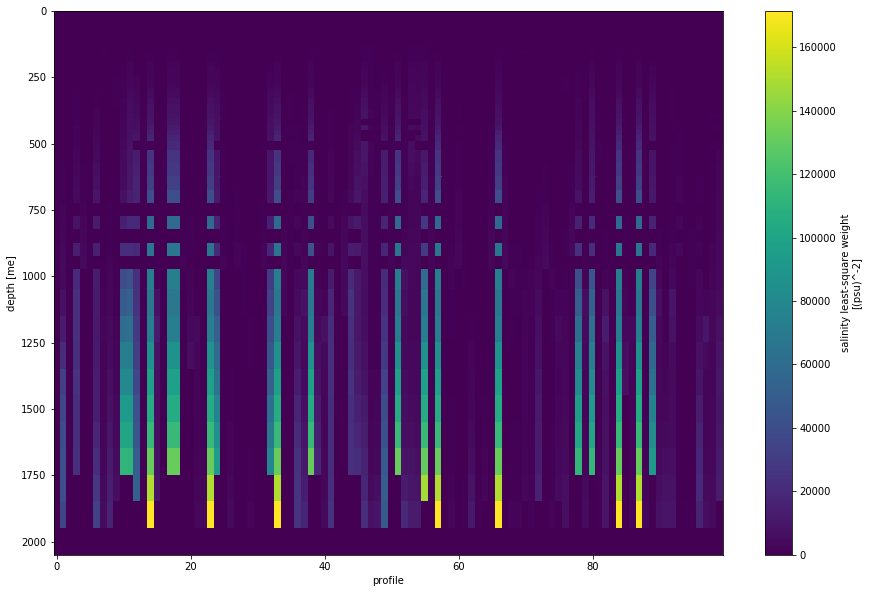

In [29]:
fig, ax = plt.subplots(figsize=(15,10))
argo.prof_Sweight[subset].plot(y='depth', yincrease=False)

## SEAL

In [30]:
data_loc = '../data_so-chic/processed_MITprof/'

# open all ctd profiles
seal = xr.open_mfdataset(data_loc + 'SEALS/SEALS_*.nc', concat_dim='iPROF', combine='nested')

# only keep a subset of the variables
seal = seal.get(['prof_depth','prof_date','prof_YYYYMMDD','prof_HHMMSS','prof_lon','prof_lat',
                 'prof_basin','prof_point','prof_descr',
                 'prof_T','prof_Tweight','prof_Testim','prof_Tweight','prof_Terr','prof_Tflag',
                 'prof_S','prof_Sweight','prof_Sestim','prof_Sweight','prof_Serr','prof_Sflag'])

# extract vector of depths, add DataArray to Dataset 
seal = seal.assign(depth=seal.prof_depth[0,:])

# set depth as a coordinate
seal = seal.set_coords('depth')

# rename some of the variables
seal = seal.rename({'iPROF':'profile',
                    'prof_lon':'lon',
                    'prof_lat':'lat'})

# drop some variables
seal = seal.drop_vars({'prof_depth'})

# rename iDEPTH to just 'depth'
seal = seal.rename({'iDEPTH':'depth'})

# examine dataframe
seal

<xarray.Dataset>
Dimensions:        (depth: 55, profile: 203857)
Coordinates:
  * depth          (depth) float64 dask.array<chunksize=(55,), meta=np.ndarray>
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    lon            (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    prof_basin     (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    prof_point     (profile) float64 dask.array<chunksize=(1128,), meta=np.ndarray>
    prof_descr     (profile) |S30 dask.array<chunksize=(1128,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Tweight   (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Testim    (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Terr      (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Tflag     (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_S         (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Sweight   (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Sestim    (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Serr      (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
    prof_Sflag     (profile, depth) float64 dask.array<chunksize=(1128, 55), meta=np.ndarray>
Attributes:
    Format:   The contents of this MITprof file were processed \nusing the MI...
    date:     12-May-2021

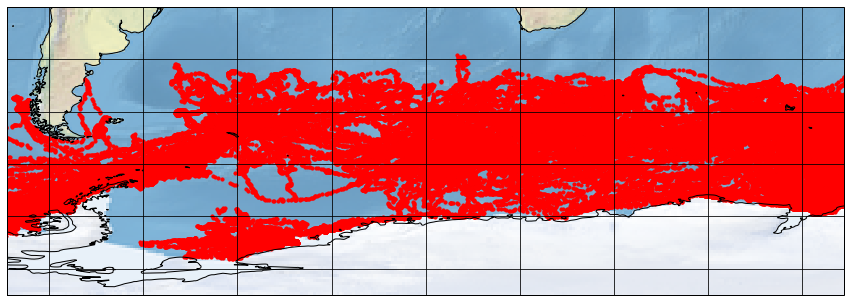

In [31]:
# extract lat/lon values
lons_plot = seal.isel(depth=0).lon.values
lats_plot = seal.isel(depth=0).lat.values

#colormap 
plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
CS = plt.scatter(lons_plot-360, 
                 lats_plot, 
                 marker='o',
                 color='red',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.stock_img()
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

Finally, the seal data has decent coverage of part of the Weddell Sea, but there are still large gaps. It will definitely be a challenge for clustering applications! 

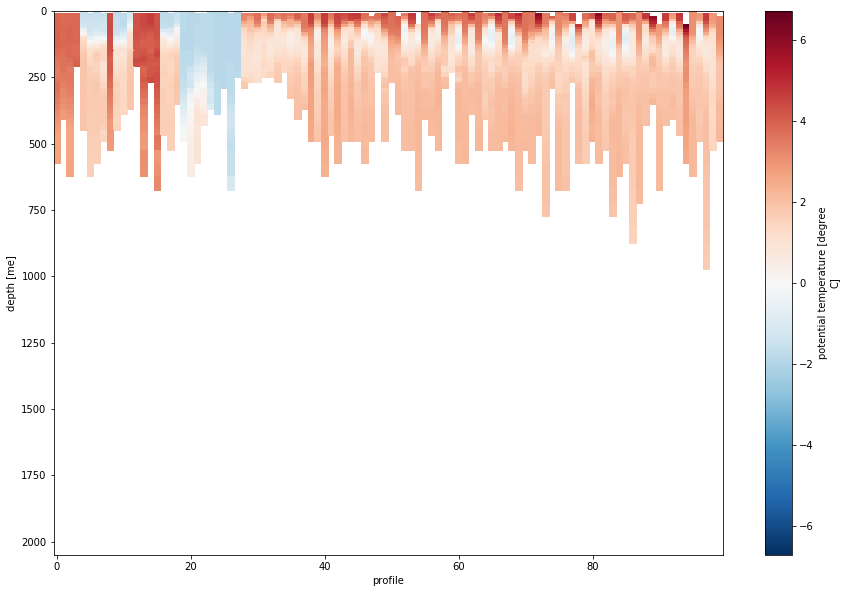

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_T[subset].plot(y='depth', yincrease=False)

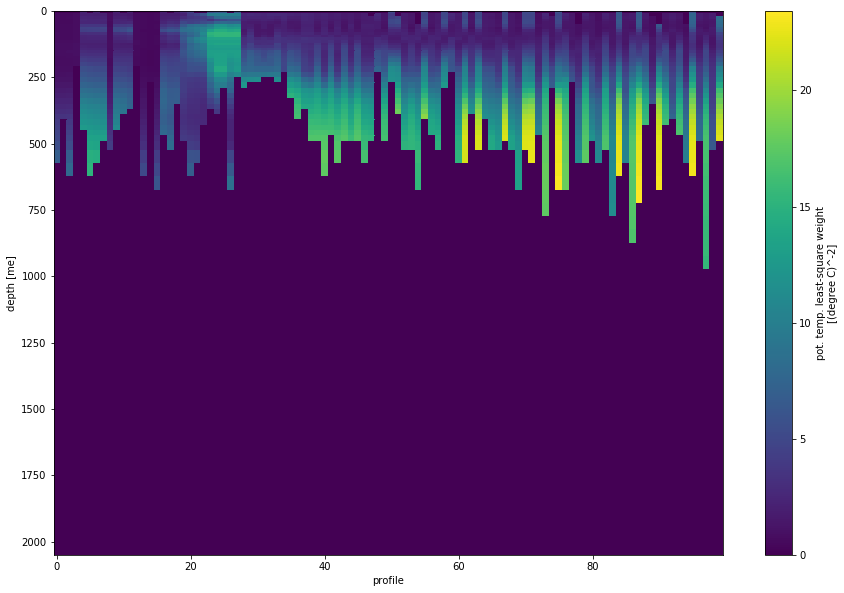

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_Tweight[subset].plot(y='depth', yincrease=False)

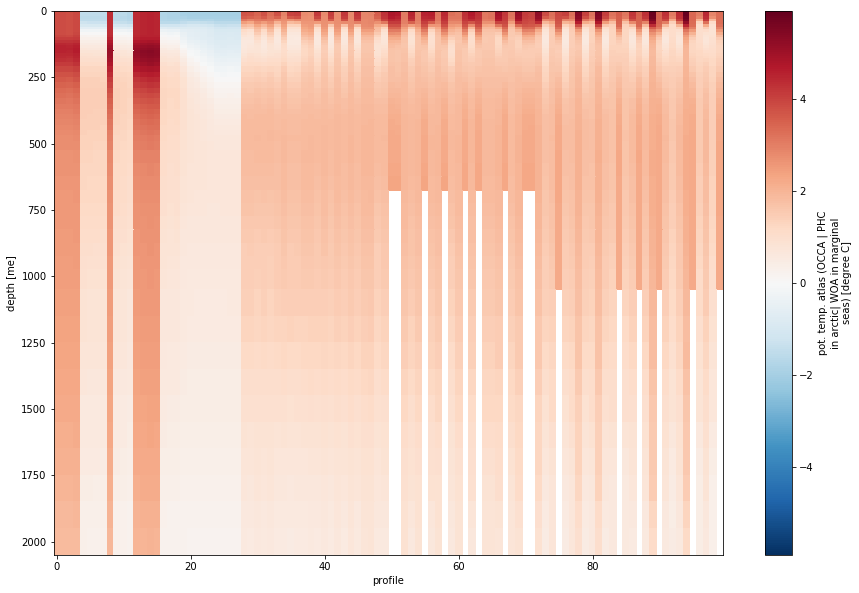

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_Testim[subset].plot(y='depth', yincrease=False)

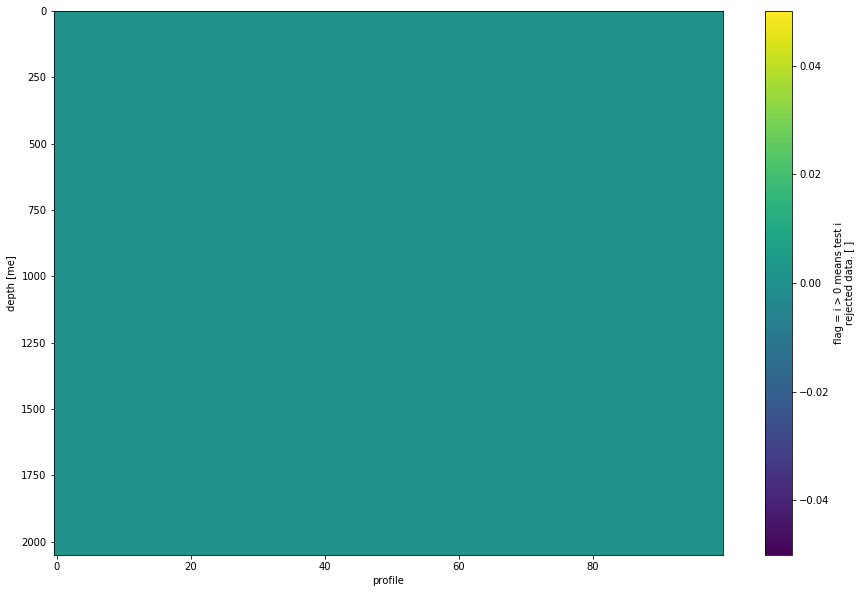

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_Tflag[subset].plot(y='depth', yincrease=False)

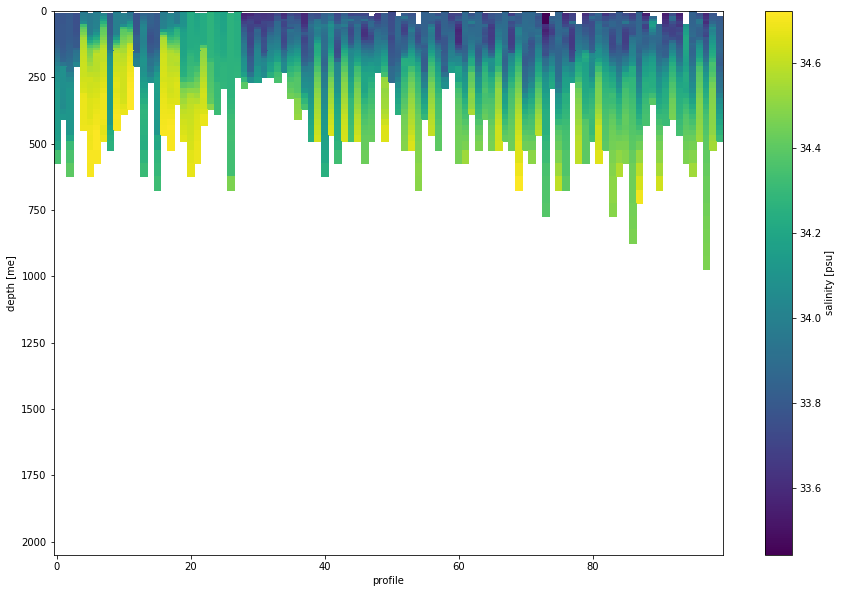

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_S[subset].plot(y='depth', yincrease=False)

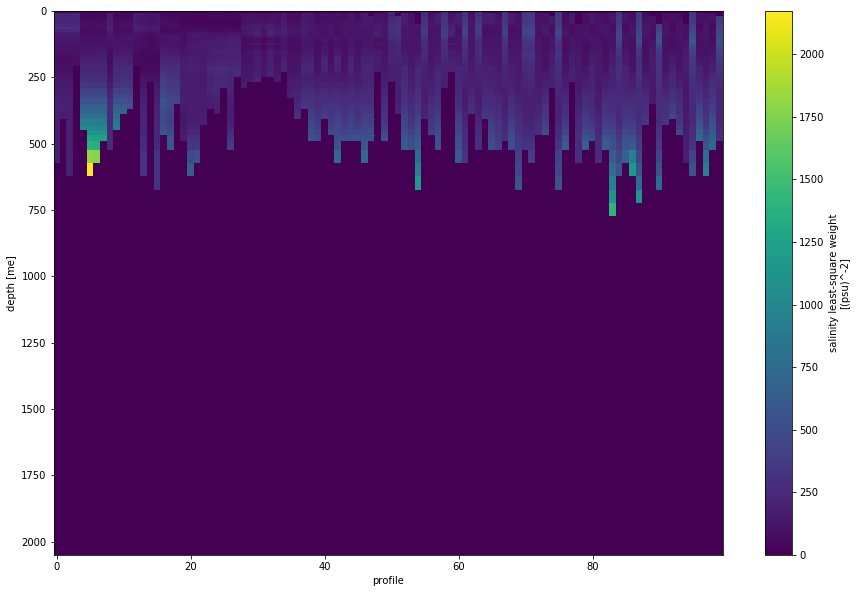

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_Sweight[subset].plot(y='depth', yincrease=False)

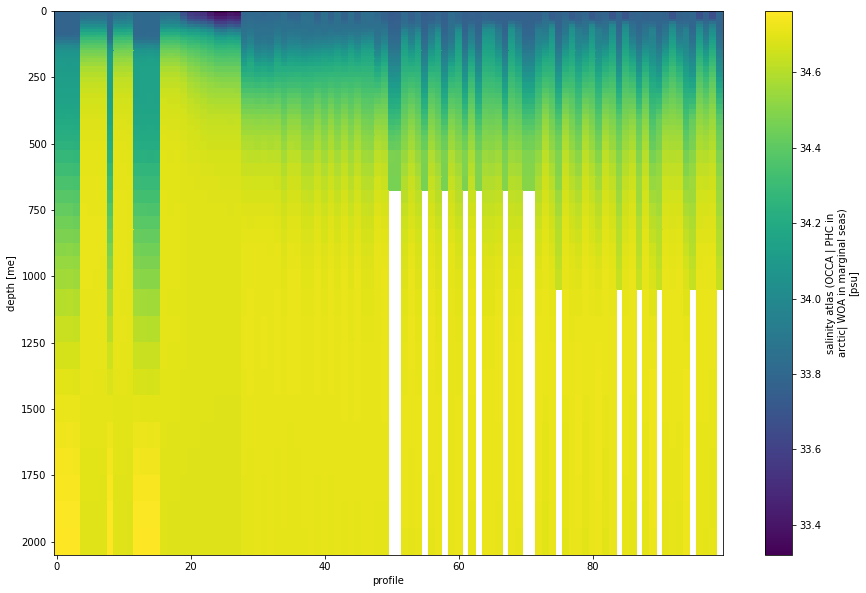

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_Sestim[subset].plot(y='depth', yincrease=False)

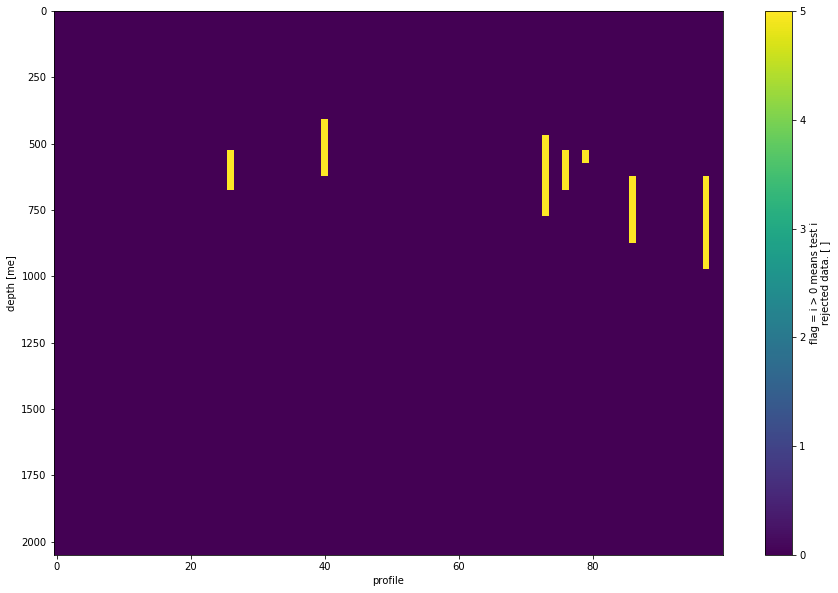

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
seal.prof_Sflag[subset].plot(y='depth', yincrease=False)

The flag values here (i=5) indicate that there is a large difference between these profiles and the climatology. I suppose that's not necessarily a problem, but it does deserve further investigation. 

## SEALS (B-SOSE)

For comparison of the data formatting, we'll plot some seal profiles from B-SOSE

In [40]:
data_loc = '../data_bsose/datasets/'

# open all ctd profiles
seal_bsose = xr.open_dataset(data_loc + 'MEO_SO_2008_MEO_D.nc')

# only keep a subset of the variables
seal_bsose = seal_bsose.get(['prof_depth','prof_date','prof_YYYYMMDD','prof_HHMMSS','prof_lon','prof_lat',
                             'prof_basin','prof_point','prof_descr',
                             'prof_T','prof_Tweight','prof_Testim','prof_Tweight','prof_Terr','prof_Tflag',
                             'prof_S','prof_Sweight','prof_Sestim','prof_Sweight','prof_Serr','prof_Sflag'])

# extract vector of depths, add DataArray to Dataset 
seal_bsose = seal_bsose.assign(depth=seal_bsose.prof_depth)

# set depth as a coordinate
seal_bsose = seal_bsose.set_coords('depth')

# rename some of the variables
seal_bsose = seal_bsose.rename({'iPROF':'profile',
                                'prof_lon':'lon',
                                'prof_lat':'lat'})

# drop some variables
seal_bsose = seal_bsose.drop_vars({'prof_depth'})

# rename iDEPTH to just 'depth'
seal_bsose = seal_bsose.rename({'iDEPTH':'depth'})

# examine dataframe
seal_bsose

<xarray.Dataset>
Dimensions:        (depth: 97, profile: 43049)
Coordinates:
  * depth          (depth) float64 2.0 4.0 7.0 10.0 ... 5.6e+03 5.8e+03 6e+03
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    lon            (profile) float64 ...
    lat            (profile) float64 ...
    prof_basin     (profile) float64 ...
    prof_point     (profile) float64 ...
    prof_descr     (profile) |S30 ...
    prof_T         (profile, depth) float64 ...
    prof_Tweight   (profile, depth) float64 ...
    prof_Testim    (profile, depth) float64 ...
    prof_Terr      (profile, depth) float64 ...
    prof_Tflag     (profile, depth) float64 ...
    prof_S         (profile, depth) float64 ...
    prof_Sweight   (profile, depth) float64 ...
    prof_Sestim    (profile, depth) float64 ...
    prof_Serr      (profile, depth) float64 ...
    prof_Sflag     (profile, depth) float64 ...
Attributes:
    description:  Format: MITprof. This file was created using \nthe matlab t...
    date:         11-Aug-2016

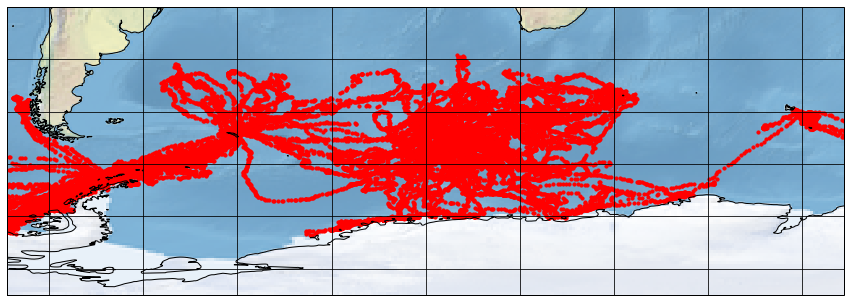

In [41]:
# extract lat/lon values
lons_plot = seal_bsose.isel(depth=0).lon.values
lats_plot = seal_bsose.isel(depth=0).lat.values

#colormap 
plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
CS = plt.scatter(lons_plot-360, 
                 lats_plot, 
                 marker='o',
                 color='red',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.stock_img()
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

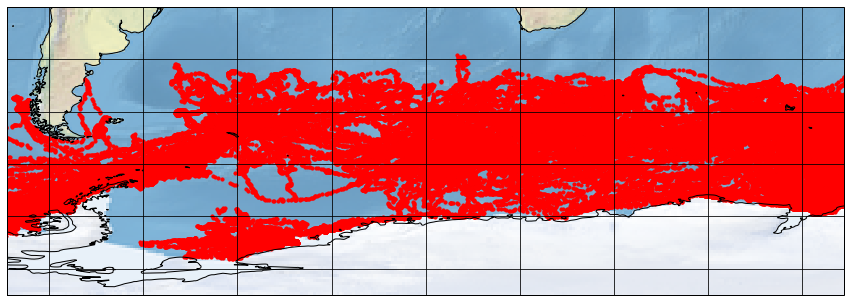

In [42]:
# extract lat/lon values
lons_plot = seal.isel(depth=0).lon.values
lats_plot = seal.isel(depth=0).lat.values

#colormap 
plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
CS = plt.scatter(lons_plot-360, 
                 lats_plot, 
                 marker='o',
                 color='red',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.stock_img()
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

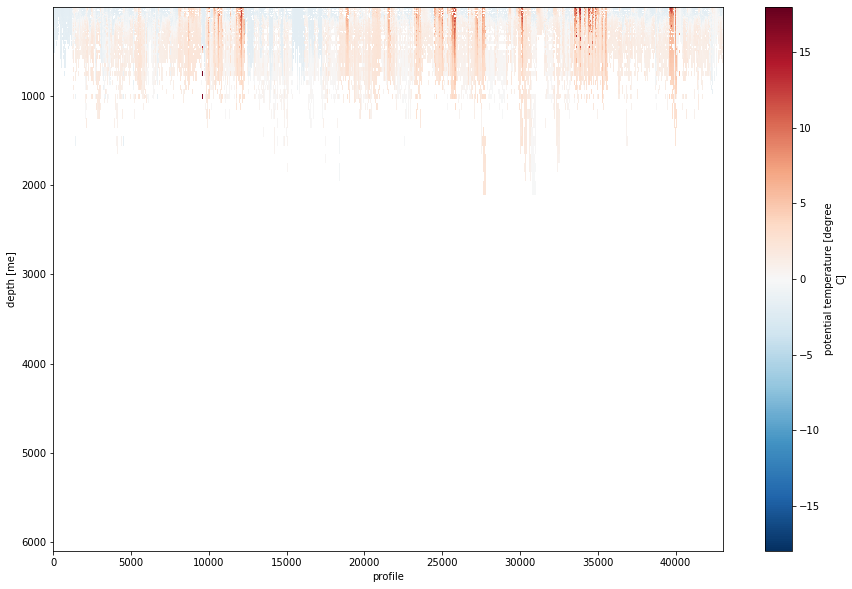

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
seal_bsose.prof_T.plot(y='depth', yincrease=False)

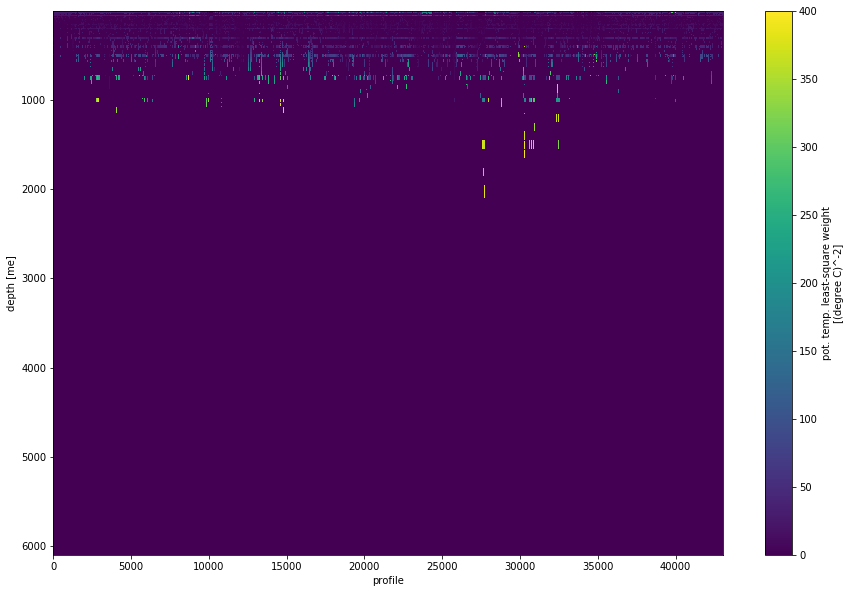

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
seal_bsose.prof_Tweight.plot(y='depth', yincrease=False)

The weights are consistent in spatial structure with the weights in our seal data; the weight values are typically smaller near the surface and larger in the subsurface. 

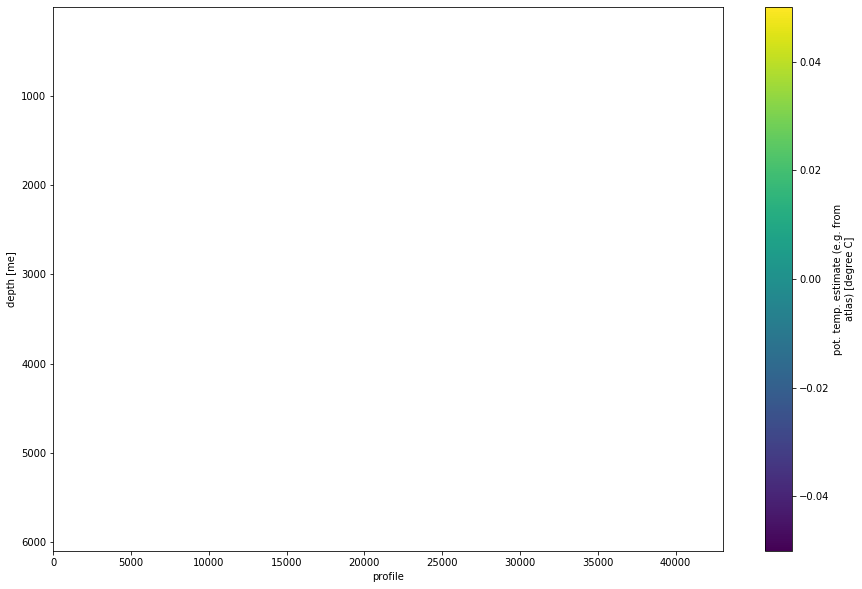

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
seal_bsose.prof_Testim.plot(y='depth', yincrease=False)

The B-SOSE seal data sample does not include an estimate from an Atlas. 

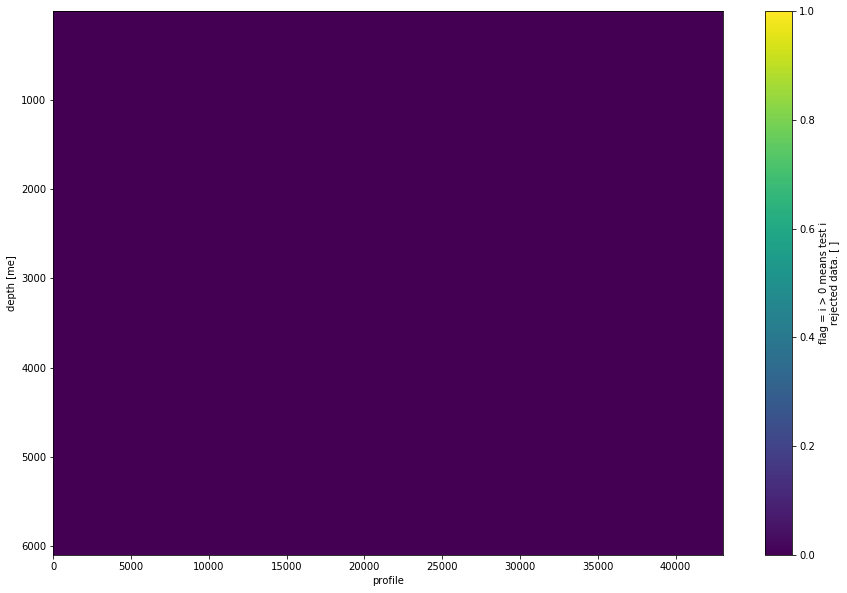

In [46]:
fig, ax = plt.subplots(figsize=(15,10))
seal_bsose.prof_Tflag.plot(y='depth', yincrease=False, vmin=0, vmax=1)

In [47]:
seal_bsose.prof_Tflag.max().values

array(0.)

In [48]:
seal_bsose.prof_Tflag.min().values

array(0.)

The fact that the B-SOSE seal data has a maximum flag value of 0 indicates that the profiles with error i>0 have been discarded in the processing, and/or that the standard levels have been selected such that the profiles tend to fall onto them. 